In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython import display
import sys
import os
import dlib
import glob
from skimage import io
from skimage.draw import circle

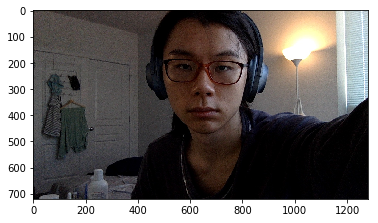

In [99]:
# uncomment to use front cam
# vc = cv2.VideoCapture(0)

# if vc.isOpened(): # try to get the first frame
#     plt.pause(0.1)
#     is_capturing, frame = vc.read()
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
#     plt.imshow(frame)    
# else:
#     is_capturing = False
# vc.release()

# test image
frame = plt.imread('test.jpg')
plt.imshow(frame) 

In [100]:
# dlib face landmarks detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

# extract land marks
def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

In [101]:
class GetEyes():
    def __init__(self, img):
        self.img = img.copy()
        landmarks = self.get_landmarks(frame)
        self.left_eye_lms = landmarks[42:47]
        self.right_eye_lms = landmarks[36:41]
        self.left_eye_rect = self.get_rect(self.left_eye_lms)
        self.right_eye_rect = self.get_rect(self.right_eye_lms)

    @staticmethod
    def get_landmarks(im):
        # extract land marks representing the eyes
        rects = detector(im, 1)

        if len(rects) > 1:
            raise TooManyFaces
        if len(rects) == 0:
            raise NoFaces

        return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])
    
    @classmethod
    def get_rect(self, landmarks):
        # get rect from eye landmarks
        border = 5
        l_ul_x = min(landmarks[:,0])
        l_ul_y = min(landmarks[:,1])
        l_lr_x = max(landmarks[:,0])
        l_lr_y = max(landmarks[:,1])
        pt1 = (np.sum(l_ul_x)-border, np.sum(l_ul_y)-border)
        pt2 = (np.sum(l_lr_x)+border, np.sum(l_lr_y)+border)
        return [pt1, pt2]
    
    def draw(self):
        # draw rect
        eimg = self.img
        eimg = cv2.rectangle(img, self.right_eye_rect[0], self.right_eye_rect[1], (255, 0, 0),thickness=3) 
        eimg = cv2.rectangle(img, self.left_eye_rect[0], self.left_eye_rect[1], (255, 0, 0),thickness=3) 
        plt.imshow(eimg)
        return eimg
    
    def crop_right_eye(self):
        # crop out right eye
        return self.img[self.right_eye_rect[0][1]:self.right_eye_rect[1][1], self.right_eye_rect[0][0]:self.right_eye_rect[1][0]]
    
    def crop_left_eye(self):
        # crop out left eye
        return self.img[self.left_eye_rect[0][1]:self.left_eye_rect[1][1], self.left_eye_rect[0][0]:self.left_eye_rect[1][0]]
        

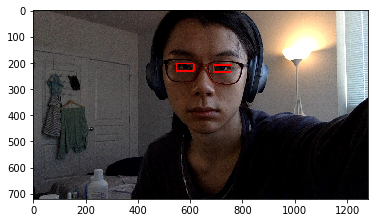

In [102]:
img = frame.copy()
eyes = GetEyes(img)
plt.imshow(eyes.draw())

In [103]:
def preprocess(img):
    # preprocess eye images
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #img = cv2.GaussianBlur(img,(3, 3),0);
    img = cv2.medianBlur(img, 5)
    windowClose = np.ones((5,5),np.uint8)
    windowOpen = np.ones((3,3),np.uint8)
    windowErode = np.ones((3,3),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, windowClose)
    #img = cv2.morphologyEx(img, cv2.MORPH_ERODE, windowErode)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, windowOpen)
    #plt.imshow(img)
    return img
    
def detect_pupil(img):
    output = img.copy()
    if len(img.shape)==3:
        # use red channel because of human comlexion
        img = preprocess(img[:,:,0])
    # detect circles in the image
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, int(img.shape[1]/3),200,100,8,8)
    
    # ensure at least some circles were found
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # draw the circle in the output image, then draw a rectangle
            # corresponding to the center of the circle
            cv2.circle(output, (x, y), r, (255, 255, 255), 1)
            cv2.rectangle(output, (x - 2, y - 2), (x + 2, y + 2), (255, 0, 0), 1)
    return circles, output

# def CannyThreshold(img, lowThreshold, kernel_size):  
#     detected_edges = cv2.GaussianBlur(img,(5, 5),0)  
#     detected_edges = cv2.Canny(detected_edges,lowThreshold,lowThreshold*ratio,apertureSize = kernel_size)  
#     dst = cv2.bitwise_and(img, img, mask = ~detected_edges)  # just add some colours to edges from original image.  
#     plt.imshow(dst)
#     return detected_edges


# lowThreshold = 45 
# ratio = 2 
# kernel_size = 3  
# detected_edges = CannyThreshold(eye_img_r, lowThreshold, kernel_size)  # initialization  

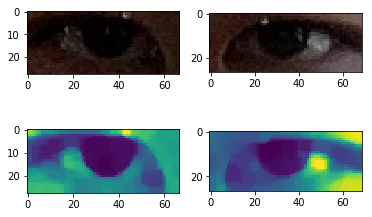

In [104]:
eye_img_r = eyes.crop_right_eye()
eye_img_l = eyes.crop_left_eye()
proc_r = preprocess(eye_img_r)
proc_l = preprocess(eye_img_l)

# display right and left eye image
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(eye_img_r)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(eye_img_l)
ax1 = fig.add_subplot(2,2,3)
ax1.imshow(proc_r)
ax2 = fig.add_subplot(2,2,4)
ax2.imshow(proc_l)

[[36 10 11]]
[[32 10 10]]


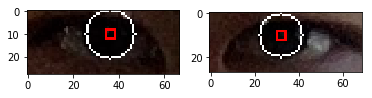

In [105]:
circles_r, output_r = detect_pupil(eye_img_r)
circles_l, output_l = detect_pupil(eye_img_l)
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(output_r)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(output_l)
print(circles_r)
print(circles_l)